# California kindergarten immunization rates

In [1]:
# Import modules

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import bokeh
from ast import literal_eval
from bokeh.resources import INLINE
from bokeh.plotting import figure, show
from bokeh.sampledata.us_states import data as states
from bokeh.models import ColumnDataSource, Range1d
from bokeh.io import output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.palettes import brewer
output_notebook(resources=INLINE)

Loading BokehJS ...

In [57]:
from scipy.stats import pearsonr, spearmanr

In [87]:
# Set plot preferences
plt.style.use('dark_background')

In [3]:
# Set pandas options
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000

## Import data

In [4]:
df_geo = pd.read_csv('data/geoData.csv')

In [5]:
df_infant = pd.read_csv('data/InfantData.csv')

In [6]:
df_pert = pd.read_csv('data/pertusisRates2010_2015.csv')

In [7]:
df_student = pd.read_csv('data/StudentData.csv')

## Useful functions

In [8]:
def basic_usa_geo_plot(df, plot_width, plot_height):
    source_geo = ColumnDataSource(data=dict(lat=df['latitude'].values, lon=df['longitude'].values))
    state_lats = [states[code]['lats'] for code in states]
    state_longs = [states[code]['lons'] for code in states]
    p = figure(toolbar_location="left",
               plot_width=3000,
               plot_height=2000)
    # determine range to print based on min, max lat and long of the data
    margin = .2 # buffer to add to the range
    lat_min = df['latitude'].min() - margin
    lat_max = df['latitude'].max() + margin
    long_min = df['longitude'].min() - margin
    long_max = df['longitude'].max() + margin
    
    p.y_range = Range1d(lat_min, lat_max)
    p.x_range = Range1d(long_min, long_max)
    p.xaxis.visible = False
    p.yaxis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    p.patches(state_longs, 
              state_lats, 
              fill_alpha=0.0,
              line_color="black", 
              line_width=2, 
              line_alpha=0.3)

    p.circle(x="lon", 
             y="lat", 
             source=source_geo, 
             size=4.5,
             fill_color='red',
             line_color='grey',
             line_alpha=.25)
    
    show(p)

In [9]:
def merc(lat, lon):
    # Radius of the earth in meters
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [10]:
def geo_plot_world(df, lat_col, lon_col, colour_col=None):
    df_to_use = df[[lat_col, lon_col]]
    df_to_use['x_coord'] = df_to_use.apply(lambda row: merc(lat=row[lat_col], 
                                                            lon=row[lon_col])[0], axis=1)
    df_to_use['y_coord'] = df_to_use.apply(lambda row: merc(lat=row[lat_col], 
                                                            lon=row[lon_col])[1], axis=1)
#     source_geo = ColumnDataSource(data=dict(x_coord=df_to_use['x_coord'].values, 
#                                             y_coord=df_to_use['y_coord'].values))
    
    # determine range to print based on min, max lat and long of the data
    margin = .2 # buffer to add to the range
    lat_min = df[lat_col].min() - margin
    lat_max = df[lat_col].max() + margin
    lon_min = df[lon_col].min() - margin
    lon_max = df[lon_col].max() + margin
    
    merc_min_range = merc(lat_min, lon_min)
    merc_max_range = merc(lat_max, lon_max)
    
    merc_x_min = merc_min_range[0]
    merc_y_min = merc_min_range[1]
    merc_x_max = merc_max_range[0]
    merc_y_max = merc_max_range[1]
    
    p = figure(toolbar_location='left', 
           x_range=(merc_x_min, merc_x_max), y_range=(merc_y_min, merc_y_max),
           x_axis_type="mercator", y_axis_type="mercator")
    
    p.add_tile(CARTODBPOSITRON)
    
    if colour_col:
        # Get the number of colours we'll need
        len_ = len(df[colour_col].unique())
        while len_ < 3:
            len_ += 1
        colours = brewer["PuRd"][len_]
        
        # Create a map between factor and color.
        colourmap = {i: colours[i] for i in df[colour_col].unique()}
        
        # Create a list of colors for each value that we will be looking at.
        colours = [colourmap[x] for x in df[colour_col]]
        
        source_geo = ColumnDataSource(data=dict(x_coord=df_to_use['x_coord'].values, 
                                      y_coord=df_to_use['y_coord'].values,
                                      colouring=colours))
    
        p.circle(x="x_coord", 
                 y="y_coord",
                 color="colouring",
                 source=source_geo,
                 size=4.5)
    else:
        source_geo = ColumnDataSource(data=dict(x_coord=df_to_use['x_coord'].values, 
                                      y_coord=df_to_use['y_coord'].values))
        p.circle(x="x_coord", 
                 y="y_coord", 
                 source=source_geo, 
                 size=4.5,
                 fill_color='red',
                 line_color='grey',
                 line_alpha=.25)
    show(p)

## Geo data

In [11]:
df_geo.head()

,longitude,latitude,school_code,countyMatch,isSchool
0,-122.215864,37.803399,7092463,1,1
1,-121.882682,37.716306,6972533,1,1
2,-122.196244,37.758459,7082266,1,1
3,-122.234422,37.782892,6910343,1,1
4,-122.243885,37.768844,6967434,1,1


## Columns:
* school_code: Unique integer code for each school (consistent across years)
* countyMatch: indicator variable is entry is in the appropriate county
* isSchool: indicator variable (if search returned "school")

In [12]:
df_geo.shape

(10023, 5)

In [13]:
df_geo['school_code'].nunique()

10023

In [14]:
# So each row is unique for school code.
df_geo[df_geo['school_code'].isnull()].shape

(0, 5)

In [15]:
df_geo['countyMatch'].value_counts()

1    9350
0     673
Name: countyMatch, dtype: int64

In [16]:
df_geo[df_geo['countyMatch'].isnull()].shape

(0, 5)

In [17]:
9350 + 673

10023

In [18]:
# So all good here.
df_geo[df_geo['isSchool'].isnull()].shape

(0, 5)

In [19]:
df_geo['isSchool'].value_counts()

1    8997
0    1026
Name: isSchool, dtype: int64

In [20]:
8997 + 1026

10023

In [102]:
df_geo.isnull().any()

longitude      False
latitude       False
school_code    False
countyMatch    False
isSchool       False
dtype: bool

In [21]:
# Ok where are all of these places? They should be in california.
geo_plot_world(df=df_geo, lat_col='latitude', lon_col='longitude')

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
# So some of these places are weird. What are these odd geospatial coordinates?
geo_plot_world(df=df_geo.loc[(df_geo['countyMatch'] == 0)], 
               lat_col='latitude', 
               lon_col='longitude')

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
geo_plot_world(df=df_geo.loc[(df_geo['countyMatch'] == 1)], 
               lat_col='latitude', 
               lon_col='longitude')

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
# Beauty.  Ok so we should only consider California examples.
df_geo = df_geo.loc[(df_geo['countyMatch'] == 1)]

In [25]:
df_geo.shape

(9350, 5)

In [26]:
# Ok, how many are identified as schools
df_geo['isSchool'].value_counts()

1    8616
0     734
Name: isSchool, dtype: int64

In [27]:
# So the majority are schools.  Can we visualize to see if there is a pattern or cluster here?
geo_plot_world(df=df_geo, 
               lat_col='latitude', 
               lon_col='longitude',
               colour_col='isSchool')

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
# Unclear if there is a pattern here!  We'll keep this as a potential feature

## 2014 Infant Pertussis case info by county
* County: county name string
* Cases: number of reported pertussis cases
* Hospitalizations: Number of cases leading to hospitalization
* Deaths: Number of cases resulting in death
* Case_Rate: Case rate per 1000. Denominators adjusted to account for partial birth cohort; rate missing for counties under 1000.

In [29]:
df_infant.head()

,COUNTY,Cases,Hospitalizations,Deaths,Case_Rate
0,ALAMEDA,10,3,0,1.0
1,ALPINE,0,0,0,0.0
2,AMADOR,0,0,0,0.0
3,BUTTE,6,5,0,5.1
4,CALAVERAS,0,0,0,0.0


In [30]:
df_infant.shape

(58, 5)

In [31]:
df_infant.describe()

,Cases,Hospitalizations,Deaths,Case_Rate
count,58.000000,58.000000,58.000000,54.000000
mean,10.620690,6.172414,0.068966,1.811111
std,23.120453,14.884512,0.255609,1.749250
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.500000,0.000000,1.450000
75%,9.750000,5.000000,0.000000,3.225000
max,143.000000,101.000000,1.000000,6.100000


In [32]:
df_infant['COUNTY'].nunique()

58

In [33]:
# Let's look at the total number of cases.
df_infant[['Cases', 'Hospitalizations', 'Deaths']].sum()

Cases               616
Hospitalizations    358
Deaths                4
dtype: int64

In [34]:
# So there are 616 cases of Pertussis in 2014.
# Out of these, 358 lead to hospitalization: about 58.1% of cases
# Four deaths total attributed to Pertussis, or: 
# about 0.65% out of all cases lead to death. 
# 1.12% of Hospitalization cases lead to death.

In [35]:
df_infant.isnull().any()

COUNTY              False
Cases               False
Hospitalizations    False
Deaths              False
Case_Rate            True
dtype: bool

In [36]:
# So the null case rates, are probably the missing ones (i.e. counties with less than 1000)
df_infant[df_infant['Case_Rate'].isnull()]

,COUNTY,Cases,Hospitalizations,Deaths,Case_Rate
5,COLUSA,1,1,0,NaN
31,PLUMAS,1,1,0,NaN
51,TEHAMA,2,2,0,NaN
52,TRINITY,2,1,0,NaN


Text(0.5,1,'Pertussis cases in 2014 by County')

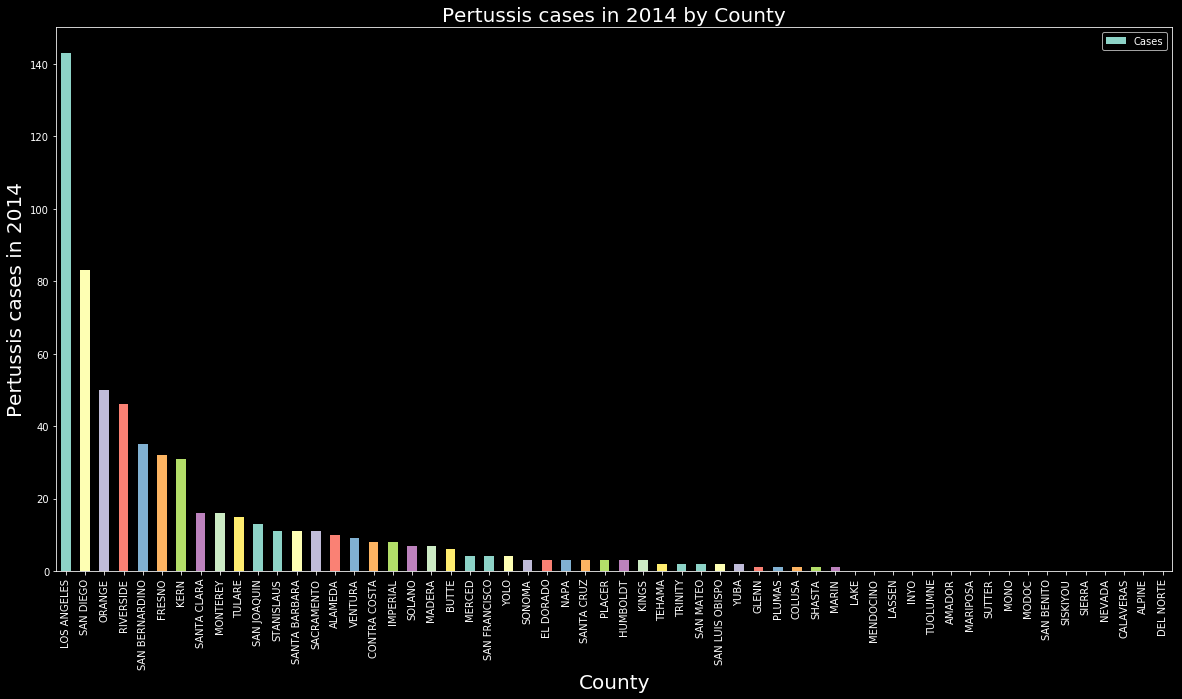

In [37]:
ax = df_infant.sort_values('Cases', 
                           ascending=False).plot(kind='bar', 
                                                 x='COUNTY', 
                                                 y='Cases', 
                                                 figsize=(20,10))
plt.xlabel('County', fontsize=20)
plt.ylabel('Pertussis cases in 2014', fontsize=20)
plt.title('Pertussis cases in 2014 by County', fontsize=20)

In [38]:
# So this is not so surprising...the top few are really just counting population.  

Text(0.5,1,'Pertussis cases which lead to hospitalization in 2014 by County')

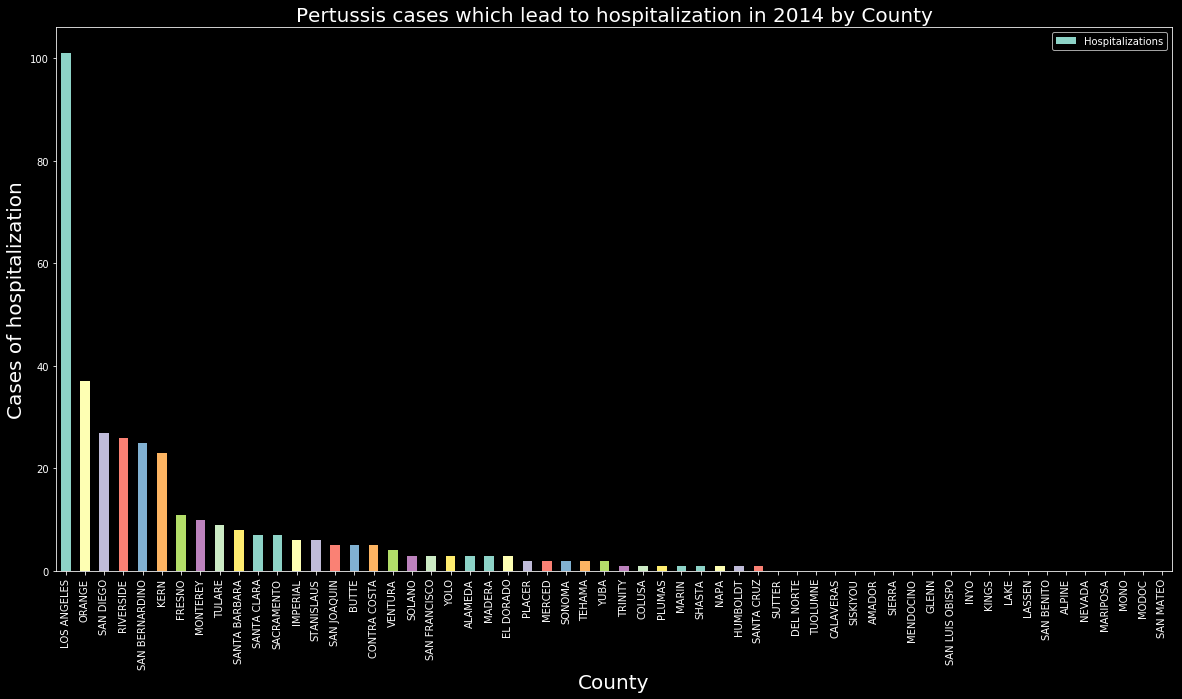

In [39]:
ax = df_infant.sort_values('Hospitalizations', 
                           ascending=False).plot(kind='bar', 
                                                 x='COUNTY', 
                                                 y='Hospitalizations', 
                                                 figsize=(20,10))
plt.xlabel('County', fontsize=20)
plt.ylabel('Cases of hospitalization', fontsize=20)
plt.title('Pertussis cases which lead to hospitalization in 2014 by County', fontsize=20)

In [40]:
# Which seems to more or less follow the trend in number of cases.  So the higher the number 
# of cases, the greater the chance of hospitalization.  No surprise there.

Text(0.5,1,'Pertussis cases which lead to death in 2014 by County')

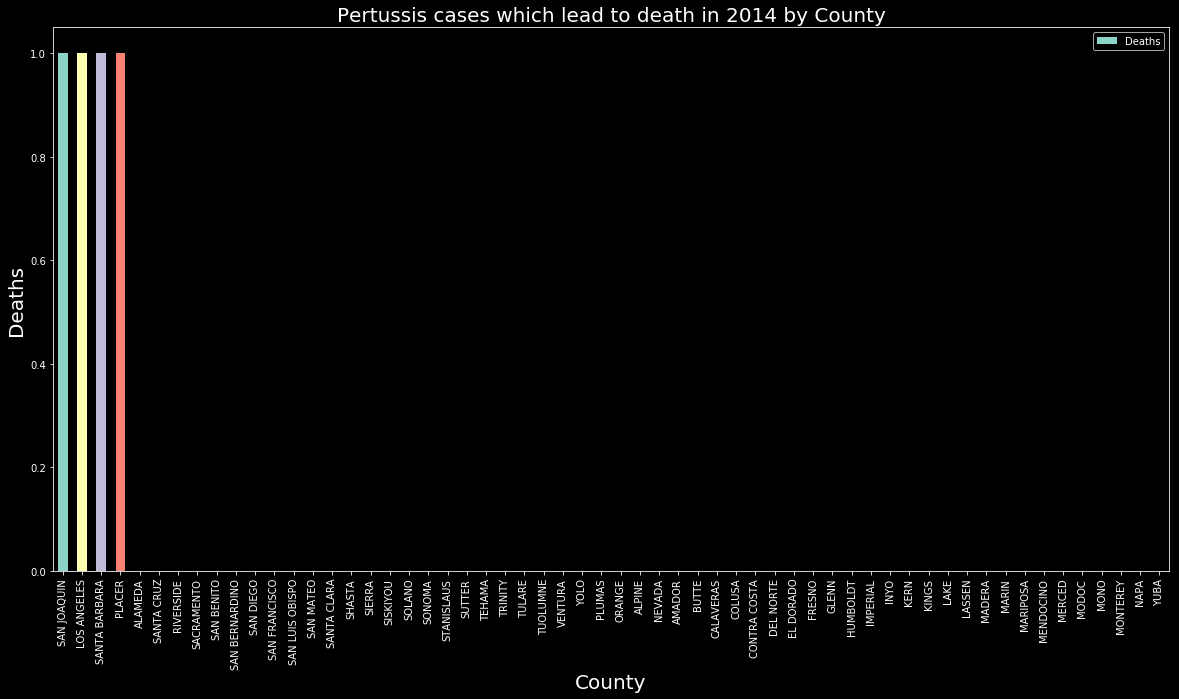

In [41]:
ax = df_infant.sort_values('Deaths', 
                           ascending=False).plot(kind='bar', 
                                                 x='COUNTY', 
                                                 y='Deaths', 
                                                 figsize=(20,10))
plt.xlabel('County', fontsize=20)
plt.ylabel('Deaths', fontsize=20)
plt.title('Pertussis cases which lead to death in 2014 by County', fontsize=20)

In [89]:
# There was one death in the following counties:
# San Joaquin
# Los Angeles
# Santa Barbara 
# Placer

Text(0.5,1,'Pertussis rates per 1000 in 2014 by County')

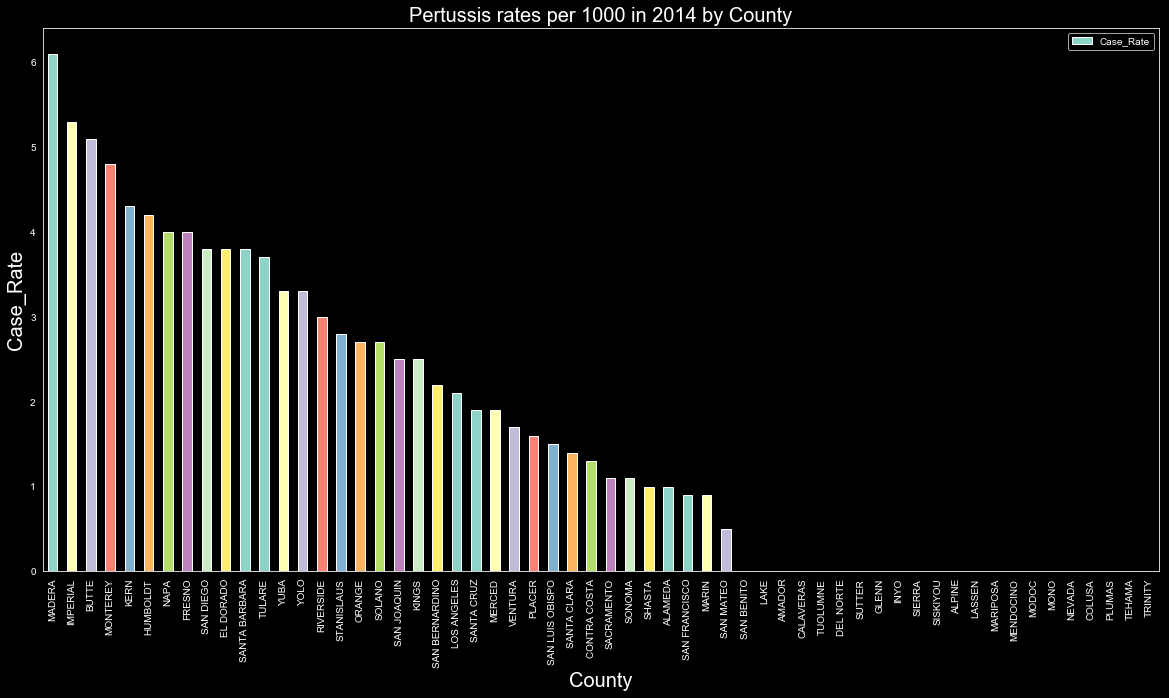

In [88]:
ax = df_infant.sort_values('Case_Rate', 
                           ascending=False).plot(kind='bar', 
                                                 x='COUNTY', 
                                                 y='Case_Rate', 
                                                 figsize=(20,10))
plt.xlabel('County', fontsize=20)
plt.ylabel('Case_Rate', fontsize=20)
plt.title('Pertussis rates per 1000 in 2014 by County', fontsize=20)

In [43]:
# Let's contrast the number of cases against number of hospitalizations, 
# and cases versus deaths
# and hospitalizations vs death.

In [85]:
sns.set_style("dark")

Text(0.5,0.98,'Number of cases vs hospitalizations')

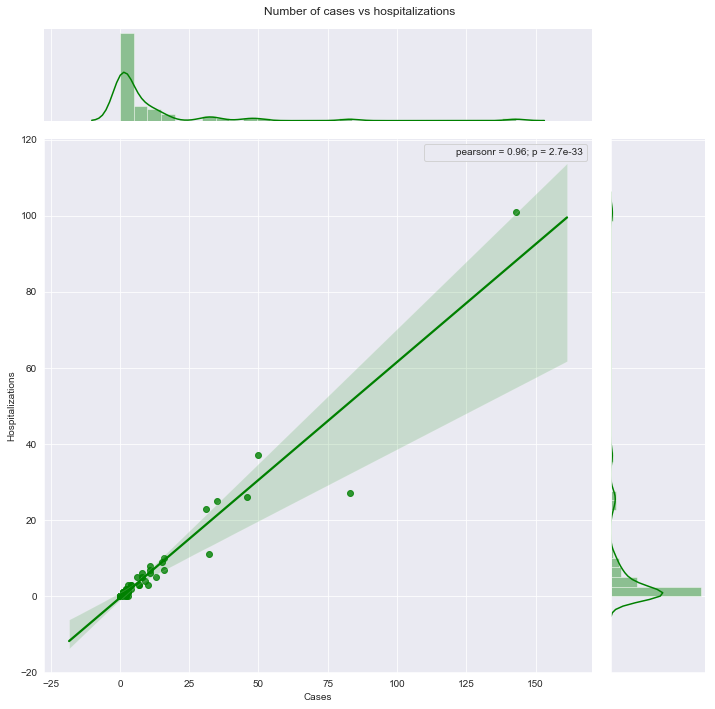

In [72]:
with sns.axes_style('darkgrid'):
    g = sns.jointplot(data=df_infant, 
                      x='Cases', 
                      y='Hospitalizations', 
                      kind='reg', 
                      stat_func=pearsonr,
                      color='g',
                      height=10)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Number of cases vs hospitalizations')

In [73]:
# So there is some evidence that there is a linear relationship between the number of 
# hospitalizations and cases, although, this is largely grouped around the bottom.

Text(0.5,0.98,'Number of cases vs deaths')

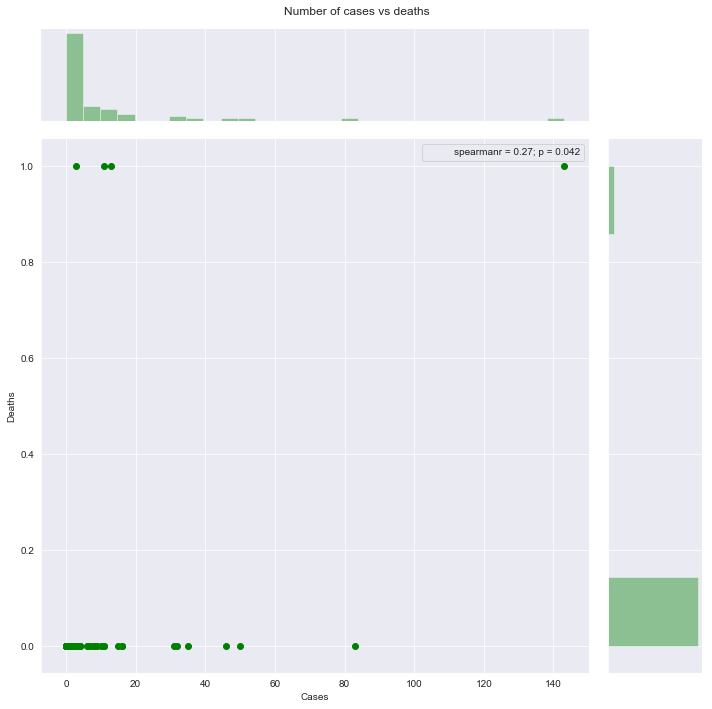

In [76]:
with sns.axes_style('darkgrid'):
    g = sns.jointplot(data=df_infant, 
                      x='Cases', 
                      y='Deaths', 
                      kind='scatter', 
                      stat_func=spearmanr,
                      color='g',
                      height=10)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Number of cases vs deaths')

In [77]:
# Doesn't look like a strong signal here.  Some counties with deaths happen where there are
# actually very few cases.  Not really enough observations to say for sure.  

Text(0.5,0.98,'Number of Hospitalizations vs deaths')

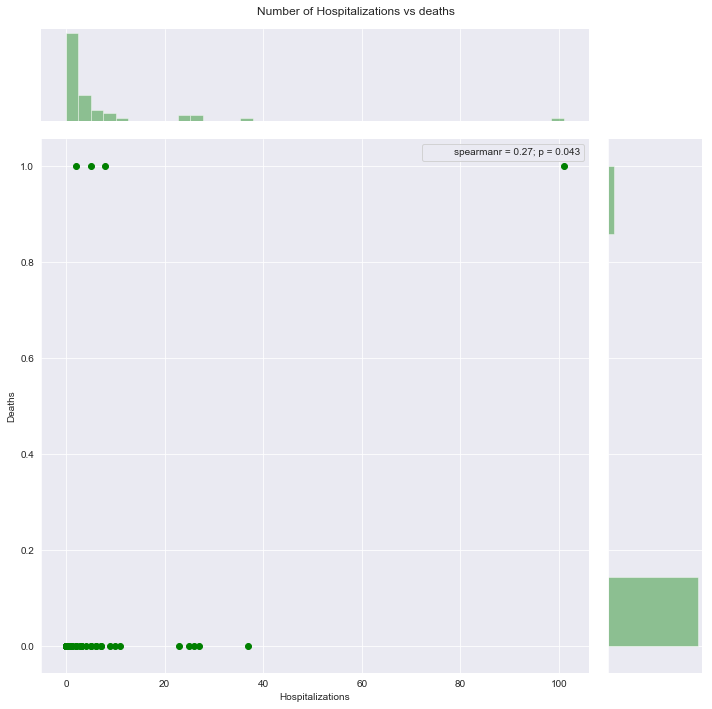

In [78]:
with sns.axes_style('darkgrid'):
    g = sns.jointplot(data=df_infant, 
                      x='Hospitalizations', 
                      y='Deaths', 
                      kind='scatter', 
                      stat_func=spearmanr,
                      color='g',
                      height=10)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Number of Hospitalizations vs deaths')

In [79]:
# Same here.  We don't really enough enough data points, but it doesn't necessarily look like
# much of a relationship.  

Text(0.5,0.98,'Case rates per 1000 vs number of hospitalizations')

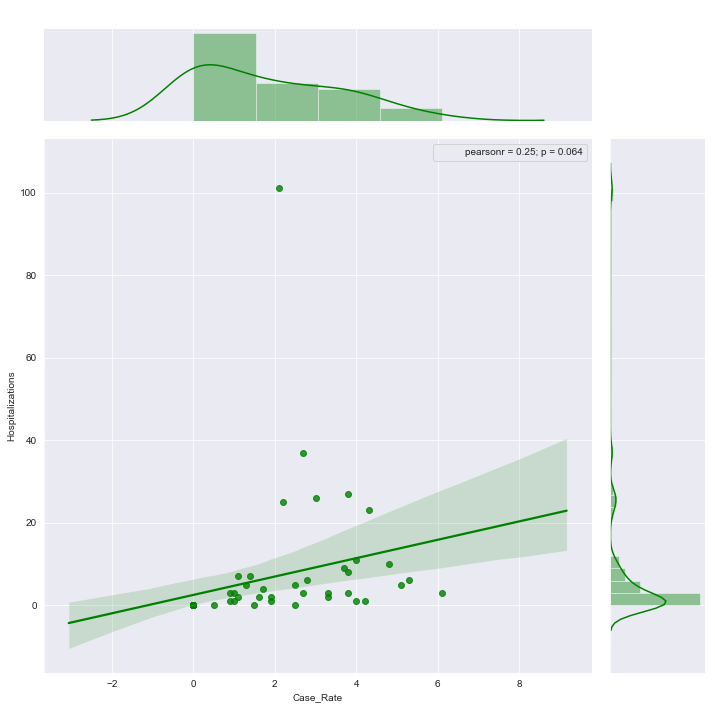

In [98]:
with sns.axes_style('darkgrid'):
    g = sns.jointplot(data=df_infant, 
                      x='Case_Rate', 
                      y='Hospitalizations', 
                      kind='reg', 
                      stat_func=pearsonr,
                      color='g',
                      height=10)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Case rates per 1000 vs number of hospitalizations')

Text(0.5,0.98,'Case rates per 1000 vs number of deaths')

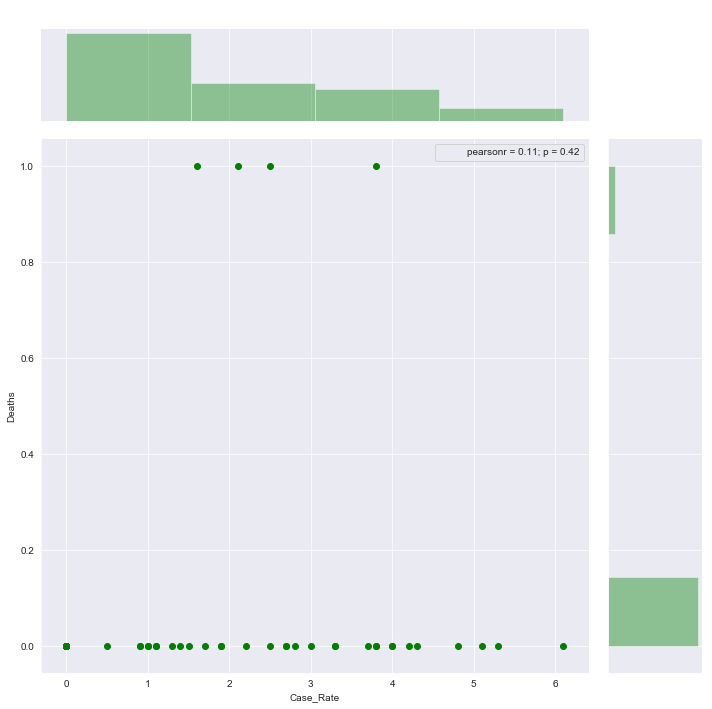

In [100]:
with sns.axes_style('darkgrid'):
    g = sns.jointplot(data=df_infant, 
                      x='Case_Rate', 
                      y='Deaths', 
                      kind='scatter', 
                      stat_func=pearsonr,
                      color='g',
                      height=10)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Case rates per 1000 vs number of deaths')

In [101]:
# Not a clear relationship here either.  

## Pertussis data for cases and rates per 100,000 by county

In [104]:
df_pert.head()

,county,Cases2010,Rate2010,Cases2011,Rate2011,Cases2012,Rate2012,Cases2013,Rate2013,Cases2014,Rate2014
0,CALIFORNIA,9159,24.55,3016,8.03,1023,2.70,2537,6.64,10831,28.35
1,ALAMEDA,423,30.21,206,14.59,62,4.35,124,8.55,354,24.41
2,ALPINE,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00
3,AMADOR,4,10.56,11,29.48,1,2.74,2,5.52,1,2.76
4,BUTTE,32,14.55,16,7.26,3,1.36,33,14.87,30,13.52


In [105]:
# The rates here are a bit strange.  They are by 100,000.  Previously, they were by 1,000.
df_pert.isnull().any()

county       False
Cases2010    False
Rate2010     False
Cases2011    False
Rate2011     False
Cases2012    False
Rate2012     False
Cases2013    False
Rate2013     False
Cases2014    False
Rate2014     False
dtype: bool

In [106]:
df_pert.describe()

,Cases2010,Rate2010,Cases2011,Rate2011,Cases2012,Rate2012,Cases2013,Rate2013,Cases2014,Rate2014
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,308.694915,30.208136,101.644068,7.079492,34.491525,4.497627,85.474576,7.574746,362.728814,27.625085
std,1198.924737,30.337680,399.148307,6.160785,135.777883,18.830818,334.148241,13.144123,1432.433315,28.946509
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.500000,11.395000,2.000000,3.155000,0.000000,0.000000,2.000000,1.815000,7.500000,8.860000
50%,40.000000,21.310000,12.000000,5.600000,5.000000,2.100000,10.000000,4.280000,38.000000,17.460000
75%,198.000000,43.120000,58.000000,9.395000,17.500000,3.120000,52.500000,6.935000,178.000000,33.835000
max,9159.000000,138.900000,3016.000000,29.480000,1023.000000,146.070000,2537.000000,71.910000,10831.000000,142.180000


In [134]:
# Are the 2014 rates here the same as the infant rates?
df_test_rates = df_pert[['county', 'Cases2014', 'Rate2014']]

In [137]:
df_test_rates.rename(index=str, columns={'county': 'COUNTY'}, inplace=True)

In [156]:
df_test_rates = df_test_rates.merge(df_infant, on='COUNTY', how='left')

In [157]:
df_test_rates

,COUNTY,Cases2014,Rate2014,Cases,Hospitalizations,Deaths,Case_Rate
0,CALIFORNIA,10831,28.35,NaN,NaN,NaN,NaN
1,ALAMEDA,354,24.41,10.0,3.0,0.0,1.0
2,ALPINE,0,0.00,0.0,0.0,0.0,0.0
3,AMADOR,1,2.76,0.0,0.0,0.0,0.0
4,BUTTE,30,13.52,6.0,5.0,0.0,5.1
5,CALAVERAS,17,37.35,0.0,0.0,0.0,0.0
6,COLUSA,0,0.00,1.0,1.0,0.0,NaN
7,CONTRA COSTA,463,42.78,8.0,5.0,0.0,1.3
8,DEL NORTE,2,7.16,0.0,0.0,0.0,0.0
9,EL DORADO,33,18.00,3.0,3.0,0.0,3.8


In [158]:
# Are the rates and cases the same?
df_test_rates.loc[(df_test_rates['Cases2014'] != df_test_rates['Cases'])]

,COUNTY,Cases2014,Rate2014,Cases,Hospitalizations,Deaths,Case_Rate
0,CALIFORNIA,10831,28.35,NaN,NaN,NaN,NaN
1,ALAMEDA,354,24.41,10.0,3.0,0.0,1.0
3,AMADOR,1,2.76,0.0,0.0,0.0,0.0
4,BUTTE,30,13.52,6.0,5.0,0.0,5.1
5,CALAVERAS,17,37.35,0.0,0.0,0.0,0.0
6,COLUSA,0,0.00,1.0,1.0,0.0,NaN
7,CONTRA COSTA,463,42.78,8.0,5.0,0.0,1.3
8,DEL NORTE,2,7.16,0.0,0.0,0.0,0.0
9,EL DORADO,33,18.00,3.0,3.0,0.0,3.8
10,FRESNO,391,40.78,32.0,11.0,0.0,4.0


In [161]:
# Right, they aren't the same. Yeah I suspect that the df_infant data is only for infant
# cases, whereas the df_pert data has all cases recorded.  
df_test_rates.loc[(df_test_rates['Cases2014'] < df_test_rates['Cases'])]

,COUNTY,Cases2014,Rate2014,Cases,Hospitalizations,Deaths,Case_Rate
6,COLUSA,0,0.0,1.0,1.0,0.0,NaN


In [162]:
# So in Colusa county, something odd happened :P 
# This can't be right.